In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

import src.data_processing as data
import src.models as models

In [2]:
dropped = data.numeric.read_raw_csv_numeric('../data/cleaned/hmda_2017_ca_all-records_agg_sex.csv',numeric_code=True)
dropped.dtypes # Need to fix the applicant_races

loan_type                float64
property_type            float64
loan_purpose             float64
owner_occupancy          float64
loan_amount_000s         float64
preapproval              float64
action_taken             float64
county_code              float64
applicant_race_1         float64
co_applicant_race_1      float64
co_applicant_race_2      float64
co_applicant_race_3      float64
co_applicant_race_4      float64
co_applicant_race_5      float64
applicant_sex            float64
co_applicant_sex         float64
applicant_income_000s    float64
denial_reason_1          float64
denial_reason_2          float64
denial_reason_3          float64
has_co_applicant            bool
approved                    bool
applicant_races            int64
dtype: object

## Preprocessing: Choosing features & data cleaning

In [3]:
feature_cols = [# 'loan_type', 'property_type', 'loan_purpose', 'owner_occupancy',
       'loan_amount_000s', 'owner_occupancy','loan_purpose', # 'preapproval', 'action_taken', 'county_code',
       # 'applicant_race_1', 'co_applicant_race_1', 'co_applicant_race_2',
       # 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5', 'co_applicant_sex', 
       'applicant_sex','applicant_income_000s',
       # 'denial_reason_1', 'denial_reason_2', 'denial_reason_3', 'approved',
       'has_co_applicant', 'applicant_races']
dropped['applicant_races'] = dropped['applicant_races'].astype('string', copy=False)
approved = dropped.approved.astype('int')
print(dropped.dtypes)

loan_type                float64
property_type            float64
loan_purpose             float64
owner_occupancy          float64
loan_amount_000s         float64
preapproval              float64
action_taken             float64
county_code              float64
applicant_race_1         float64
co_applicant_race_1      float64
co_applicant_race_2      float64
co_applicant_race_3      float64
co_applicant_race_4      float64
co_applicant_race_5      float64
applicant_sex            float64
co_applicant_sex         float64
applicant_income_000s    float64
denial_reason_1          float64
denial_reason_2          float64
denial_reason_3          float64
has_co_applicant            bool
approved                    bool
applicant_races           string
dtype: object


### Encode enumeration data & normalize numeric data

In [4]:
# features = pd.DataFrame(index=feat_df.index)
features = []
for name in feature_cols:
    if dropped[name].dtype == 'float':
        print("Numerical feature:", name)
        f = models.feature.numeric_feature(dropped[name],log=True)
        print(f.shape, f.dtypes)
        features.append(f)
    elif name == 'applicant_races':
        print("Multi-value enumeration feature:", name)
        f = models.feature.multi_enumerate_feature(dropped[name])
        print(f.shape, f.dtypes)
        features.append(f)
    else:
        print("Enumeration feature:", name)
        f = models.feature.enumerate_feature(dropped[name])
        print(f.shape, f.dtypes)
        features.append(f)
features = pd.concat(features + [approved], axis=1)
print(features.columns)
print(features.dtypes)

Numerical feature: loan_amount_000s
(1714459,) float64
Numerical feature: owner_occupancy
(1714459,) float64
Numerical feature: loan_purpose
(1714459,) float64
Numerical feature: applicant_sex
(1714459,) float64
Numerical feature: applicant_income_000s
(1714459,) float64
Enumeration feature: has_co_applicant
(1714459, 2) has_co_applicant_False    uint8
has_co_applicant_True     uint8
dtype: object
Multi-value enumeration feature: applicant_races
(1714459, 7) applicant_races_5    float64
applicant_races_2    float64
applicant_races_6    float64
applicant_races_3    float64
applicant_races_1    float64
applicant_races_7    float64
applicant_races_4    float64
dtype: object
Index(['loan_amount_000s', 'owner_occupancy', 'loan_purpose', 'applicant_sex',
       'applicant_income_000s', 'has_co_applicant_False',
       'has_co_applicant_True', 'applicant_races_5', 'applicant_races_2',
       'applicant_races_6', 'applicant_races_3', 'applicant_races_1',
       'applicant_races_7', 'applicant_

### Drop NaN values for training

In [5]:
print(features.isna().sum())
features.dropna(inplace=True)

loan_amount_000s             945
owner_occupancy                0
loan_purpose                   0
applicant_sex                  0
applicant_income_000s     195886
has_co_applicant_False         0
has_co_applicant_True          0
applicant_races_5              0
applicant_races_2              0
applicant_races_6              0
applicant_races_3              0
applicant_races_1              0
applicant_races_7              0
applicant_races_4              0
approved                       0
dtype: int64


## Training, A simple Logistic Regression model

In [6]:
y = features.approved
x = features.drop(['approved'],axis=1)
x_std = models.regression_model.regularization(x)
print(x.shape, y.shape, x_std.shape)

(1517637, 14) (1517637,) (1517637, 14)


In [7]:
# kf = KFold(n_splits=10)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_std, y, test_size=0.01, random_state=42)
res = models.regression_model.train_lr(X_train, X_test, y_train, y_test)

Show train-test split sizes -- train: (1502460, 14) (1502460,) test: (15177, 14) (15177,)
Approved cases ratio -- train: 0.80986781678048 test: 0.8082625024708441
Positive data proportion: 0.8082625024708441 ,Positive data in correct prediction: 0.999673921904296
Accuracy = tp+tn/all 0.8082625024708441
Precision = tp/tp+fp = 0.999673921904296
Recall = tp/tp+fn = 0.999673921904296


In [8]:
res

{'precision': 0.999673921904296,
 'recall': 0.999673921904296,
 'accuracy': 0.8082625024708441,
 'ratio': 0.80986781678048}

Assume we predict all instances as positve.
Clearly, then we see there's nearly no difference between this all-approved prediction and the model

## Data Augmentation

In [9]:
disapproved = features.loc[features.approved == 0]
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(x, y, test_size=0.01, random_state=4)

In [10]:
print(X_test.shape, y_test.shape)
print("Positive data proportion:", sum(y_test) / len(y_test))

(15177, 14) (15177,)
Positive data proportion: 0.8072741648547144


In [11]:
import copy

res = [res]

aug = copy.deepcopy(features)
for i in range(1,4):
    print("\nStarting Data Augmentation for the {0}-th time".format(i))
    aug = pd.concat([aug, disapproved], axis=0)
    aug_y = aug.approved
    aug_x = aug.drop(['approved'],axis=1)
    aug_x_std = models.regression_model.regularization(aug_x)
    X_train, X_test, y_train, y_test = train_test_split(aug_x_std, aug_y, test_size=0.01, random_state=42)
    aug_res = models.regression_model.train_lr(X_train, X_test, y_train, y_test)#, add_test_x=X_test, add_test_y=y_test)
    res.append(aug_res)


Starting Data Augmentation for the 1-th time
Show train-test split sizes -- train: (1788150, 14) (1788150,) test: (18063, 14) (18063,)
Approved cases ratio -- train: 0.6804910102620026 test: 0.6776836627359796
Positive data proportion: 0.6776836627359796 ,Positive data in correct prediction: 0.9586850649350649
Accuracy = tp+tn/all 0.682057244090129
Precision = tp/tp+fp = 0.9586850649350649
Recall = tp/tp+fn = 0.9648721509680581

Starting Data Augmentation for the 2-th time
Show train-test split sizes -- train: (2073841, 14) (2073841,) test: (20948, 14) (20948,)
Approved cases ratio -- train: 0.5867166287097226 test: 0.5873591751002483
Positive data proportion: 0.5873591751002483 ,Positive data in correct prediction: 0.7484061576737677
Accuracy = tp+tn/all 0.613996562917701
Precision = tp/tp+fp = 0.7484061576737677
Recall = tp/tp+fn = 0.7823472041612484

Starting Data Augmentation for the 3-th time
Show train-test split sizes -- train: (2359531, 14) (2359531,) test: (23834, 14) (23834,

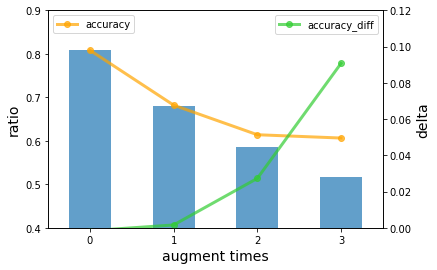

In [13]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

alpha = 0.7

fig,ax = plt.subplots()
# make a plot
ax.plot(range(len([x['accuracy'] for x in res])), [x['accuracy'] for x in res], color="orange", marker="o", lw=3, alpha=alpha, label='accuracy')
ax.bar(range(len([x['ratio'] for x in res])), [x['ratio'] for x in res], width=0.5, alpha=alpha)
# set x-axis label
ax.set_xlim([-0.5,3.5])
ax.set_xlabel("augment times",fontsize=14)
# ax.set_xlim
ax.set_xticks(np.arange(0, len([x['ratio'] for x in res]), 1))
# set y-axis label
ax.set_ylim([0.4,0.9])
ax.set_ylabel("ratio",fontsize=14)

ax2=ax.twinx()
ax2.set_ylim([0,0.12])
ax2.set_ylabel("delta",fontsize=14)
ax2.plot(range(len([x['accuracy'] for x in res])), [x['accuracy'] - x['ratio'] for x in res], color="limegreen", marker="o", lw=3, alpha=alpha, label='accuracy_diff')

ax.legend(loc='upper left')
ax2.legend(loc='best')
fig.savefig('../result/prediction/data_augment.png')
fig.show()
